In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.stats import norm, skew

from Levenshtein import distance
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import random
import math
import re

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams["axes.edgecolor"] = "black"

## Feature Engineering notebook

In [2]:
df = pd.read_csv('datasets/cleaned.csv')
df

,number,code,price,num_digits
0,1313,U,109000,4
1,3222,H,72000,4
2,30033,P,24000,5
3,7765,L,17500,4
4,8876,U,17500,4
...,...,...,...,...
3835,7210,Q,9200,4
3836,6353,E,15000,4
3837,91181,R,6500,5
3838,8704,Q,6600,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   number      3840 non-null   int64 
 1   code        3840 non-null   object
 2   price       3840 non-null   int64 
 3   num_digits  3840 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 120.1+ KB


### Extraction

In [4]:
# str helps extracting features easier
df['number'] = df['number'].astype(str)

def max_group_second(x):
    try:
        z = Counter(x).most_common(2)[1][1]
        return z
    except IndexError:
        z = Counter(x).most_common(1)[0][1]
        return z

# both capture pattern / lack of it 
df['unique_digits'] = df['number'].apply(lambda x: len(set(x)))
df['num_zeros'] = df['number'].apply(lambda x: x.count('0'))
df['max_group'] = df['number'].apply(lambda x: Counter(x).most_common(1)[0][1])
df['max_group_second'] = df['number'].apply(max_group_second)


df.head()

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second
0,1313,U,109000,4,2,0,2,2
1,3222,H,72000,4,2,0,3,1
2,30033,P,24000,5,2,2,3,2
3,7765,L,17500,4,3,0,2,1
4,8876,U,17500,4,3,0,2,1


### Entropy as a feature

$H(X) = -\Large\sum_{i=1}^{n}P_{r}(x_{i})(log_{b}P_{r}(x_{i}))$

Is a measure of the amount of information in a string, I suppose it negatively correlates with price given simple numbers tend to be more expensive than complicated ones

In [5]:
def entropy(string):
    '''Calculates the Shannon entropy of a string'''
    
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]
    return - sum(p * math.log(p) / math.log(2.0) for p in prob)

# Find H(X) for 'number' column
df['shan_entrop'] = df['number'].apply(entropy)

df.head()

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop
0,1313,U,109000,4,2,0,2,2,1.000000
1,3222,H,72000,4,2,0,3,1,0.811278
2,30033,P,24000,5,2,2,3,2,0.970951
3,7765,L,17500,4,3,0,2,1,1.500000
4,8876,U,17500,4,3,0,2,1,1.500000


## Uniqueness as a feature

In [6]:
# Will be using the lehvenshtein distance of the number with the average of all the other numbers.
# This is to check if people like unique numbers. 
# Might be double dipping given that numbers with less digits will have a 
distance('a','a')

0

${\displaystyle \qquad \operatorname {lev} (a,b)={\begin{cases}|a|&{\text{ if }}|b|=0,\\|b|&{\text{ if }}|a|=0,\\\operatorname {lev} (\operatorname {tail} (a),\operatorname {tail} (b))&{\text{ if }}a[0]=b[0]\\1+\min {\begin{cases}\operatorname {lev} (\operatorname {tail} (a),b)\\\operatorname {lev} (a,\operatorname {tail} (b))\\\operatorname {lev} (\operatorname {tail} (a),\operatorname {tail} (b))\\\end{cases}}&{\text{ otherwise.}}\end{cases}}}$

In [7]:
# df['number'].to_list()
def uniqueness(num_string,arr):
    """
    Find the average lev dist 
    between num and all other values in the array
    """   
    # Vectorize the LV dist function
    distance_vectorized = np.vectorize(distance) 
    
    # Average LV dist from string to all other values in column
    return distance_vectorized(num_string,arr).mean()


df['lv_dist'] = df['number'].apply(lambda num: uniqueness(num,df['number'].to_numpy()))

df.head()

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist
0,1313,U,109000,4,2,0,2,2,1.000000,4.181510
1,3222,H,72000,4,2,0,3,1,0.811278,4.379167
2,30033,P,24000,5,2,2,3,2,0.970951,4.507031
3,7765,L,17500,4,3,0,2,1,1.500000,4.226302
4,8876,U,17500,4,3,0,2,1,1.500000,4.254688


In [8]:
df['lv_dist'].describe()

count    3840.000000
mean        4.396552
std         0.072411
min         4.110156
25%         4.363021
50%         4.401562
75%         4.442253
max         4.615365
Name: lv_dist, dtype: float64

### Dataviz of new features, sanity check

In [9]:
# Numeric columns only
df.select_dtypes(include = [np.number]).head()

,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist
0,109000,4,2,0,2,2,1.000000,4.181510
1,72000,4,2,0,3,1,0.811278,4.379167
2,24000,5,2,2,3,2,0.970951,4.507031
3,17500,4,3,0,2,1,1.500000,4.226302
4,17500,4,3,0,2,1,1.500000,4.254688


<AxesSubplot:>

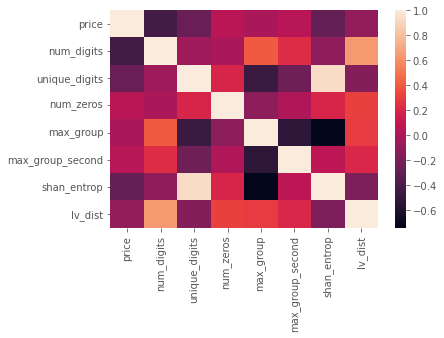

In [10]:
sns.heatmap(df.select_dtypes(include = np.number).corr())
# Doesn't seem like there is much of a correlation 
# However some strong anticorrelations 

In [11]:
# There is a chance that people like specific numbers 
# So num_x columns for all numbers might be good feature extraction
# There is a bias variance tradeoff, but given we have ~3k samples, it should be passable

nums_list = ['ones','twos','threes',
             'fours','fives','sixes',
             'sevens','eights','nines']
num_dict = {word:str(num) for word,num\
            in zip(nums_list,range(1,10))}

for word,num in num_dict.items():
    df[f'num_{word}'] = df['number'].apply(lambda x: x.count(num))
    
df.head()

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,num_twos,num_threes,num_fours,num_fives,num_sixes,num_sevens,num_eights,num_nines
0,1313,U,109000,4,2,0,2,2,1.000000,4.181510,2,0,2,0,0,0,0,0,0
1,3222,H,72000,4,2,0,3,1,0.811278,4.379167,0,3,1,0,0,0,0,0,0
2,30033,P,24000,5,2,2,3,2,0.970951,4.507031,0,0,3,0,0,0,0,0,0
3,7765,L,17500,4,3,0,2,1,1.500000,4.226302,0,0,0,0,1,1,2,0,0
4,8876,U,17500,4,3,0,2,1,1.500000,4.254688,0,0,0,0,0,1,1,2,0


In [12]:
## Set numbers back to number
df['number'] = df['number'].astype(int)

In [13]:
# Keep a copy so I can testt with different scalars
df_rob = df.copy()
df_rob.head()

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,num_twos,num_threes,num_fours,num_fives,num_sixes,num_sevens,num_eights,num_nines
0,1313,U,109000,4,2,0,2,2,1.000000,4.181510,2,0,2,0,0,0,0,0,0
1,3222,H,72000,4,2,0,3,1,0.811278,4.379167,0,3,1,0,0,0,0,0,0
2,30033,P,24000,5,2,2,3,2,0.970951,4.507031,0,0,3,0,0,0,0,0,0
3,7765,L,17500,4,3,0,2,1,1.500000,4.226302,0,0,0,0,1,1,2,0,0
4,8876,U,17500,4,3,0,2,1,1.500000,4.254688,0,0,0,0,0,1,1,2,0


### Normalizing numerical columns

In [14]:
# Keep numeric columns to apply transforms to later
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('price')
num_cols

['number',
 'num_digits',
 'unique_digits',
 'num_zeros',
 'max_group',
 'max_group_second',
 'shan_entrop',
 'lv_dist',
 'num_ones',
 'num_twos',
 'num_threes',
 'num_fours',
 'num_fives',
 'num_sixes',
 'num_sevens',
 'num_eights',
 'num_nines']

In [15]:
df[num_cols] = MinMaxScaler().fit(df[num_cols]).transform(df[num_cols])

df.head()

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,num_twos,num_threes,num_fours,num_fives,num_sixes,num_sevens,num_eights,num_nines
0,0.012519,U,109000,0.666667,0.25,0.0,0.25,0.25,0.430677,0.141237,0.4,0.00,0.4,0.0,0.00,0.00,0.000000,0.0,0.0
1,0.031622,H,72000,0.666667,0.25,0.0,0.50,0.00,0.349398,0.532474,0.0,0.75,0.2,0.0,0.00,0.00,0.000000,0.0,0.0
2,0.299923,P,24000,1.000000,0.25,0.5,0.50,0.25,0.418166,0.785567,0.0,0.00,0.6,0.0,0.00,0.00,0.000000,0.0,0.0
3,0.077085,L,17500,0.666667,0.50,0.0,0.25,0.00,0.646015,0.229897,0.0,0.00,0.0,0.0,0.25,0.25,0.666667,0.0,0.0
4,0.088203,U,17500,0.666667,0.50,0.0,0.25,0.00,0.646015,0.286082,0.0,0.00,0.0,0.0,0.00,0.25,0.333333,0.5,0.0


### Robust scaling categorical columns

In [16]:
df_rob[num_cols] = RobustScaler().fit(df_rob[num_cols]).transform(df_rob[num_cols])

df_rob.head()

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,num_twos,num_threes,num_fours,num_fives,num_sixes,num_sevens,num_eights,num_nines
0,-1.246857,U,109000,-1.0,-1.0,0.0,0.0,1.0,-3.456993,-2.777321,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.202741,H,72000,-1.0,-1.0,0.0,1.0,0.0,-4.706993,-0.282662,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.583148,P,24000,0.0,-1.0,2.0,1.0,1.0,-3.649401,1.331142,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.097754,L,17500,-1.0,0.0,0.0,0.0,0.0,-0.145241,-2.211997,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0
4,-1.072079,U,17500,-1.0,0.0,0.0,0.0,0.0,-0.145241,-1.853739,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0


### One hot encode categorical column

In [17]:
# one-hot encoder
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

# one hot encoded dataframe
df_oh = pd.DataFrame(OH_encoder.fit_transform(np.array(df['code']).reshape(-1,1)))

# Get rid of code column to replace with encoded columns
df = df.drop(['code'],axis = 1)

# join the column to the main dataframe
df = df.join(df_oh)

df.head()

,number,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,...,15,16,17,18,19,20,21,22,23,24
0,0.012519,109000,0.666667,0.25,0.0,0.25,0.25,0.430677,0.141237,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.031622,72000,0.666667,0.25,0.0,0.50,0.00,0.349398,0.532474,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.299923,24000,1.000000,0.25,0.5,0.50,0.25,0.418166,0.785567,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.077085,17500,0.666667,0.50,0.0,0.25,0.00,0.646015,0.229897,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.088203,17500,0.666667,0.50,0.0,0.25,0.00,0.646015,0.286082,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number            3840 non-null   float64
 1   price             3840 non-null   int64  
 2   num_digits        3840 non-null   float64
 3   unique_digits     3840 non-null   float64
 4   num_zeros         3840 non-null   float64
 5   max_group         3840 non-null   float64
 6   max_group_second  3840 non-null   float64
 7   shan_entrop       3840 non-null   float64
 8   lv_dist           3840 non-null   float64
 9   num_ones          3840 non-null   float64
 10  num_twos          3840 non-null   float64
 11  num_threes        3840 non-null   float64
 12  num_fours         3840 non-null   float64
 13  num_fives         3840 non-null   float64
 14  num_sixes         3840 non-null   float64
 15  num_sevens        3840 non-null   float64
 16  num_eights        3840 non-null   float64


In [19]:
df.head()

,number,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,...,15,16,17,18,19,20,21,22,23,24
0,0.012519,109000,0.666667,0.25,0.0,0.25,0.25,0.430677,0.141237,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.031622,72000,0.666667,0.25,0.0,0.50,0.00,0.349398,0.532474,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.299923,24000,1.000000,0.25,0.5,0.50,0.25,0.418166,0.785567,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.077085,17500,0.666667,0.50,0.0,0.25,0.00,0.646015,0.229897,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.088203,17500,0.666667,0.50,0.0,0.25,0.00,0.646015,0.286082,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
# Input Normalized, Output not Normalized. 
# df.to_csv('datasets/training/train.csv')

### OH encode for robust df

In [21]:
df_rob = df_rob.drop(['code'],axis = 1)

# join the column to the main dataframe
df_rob = df_rob.join(df_oh)

df_rob.head()

,number,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,...,15,16,17,18,19,20,21,22,23,24
0,-1.246857,109000,-1.0,-1.0,0.0,0.0,1.0,-3.456993,-2.777321,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.202741,72000,-1.0,-1.0,0.0,1.0,0.0,-4.706993,-0.282662,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.583148,24000,0.0,-1.0,2.0,1.0,1.0,-3.649401,1.331142,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.097754,17500,-1.0,0.0,0.0,0.0,0.0,-0.145241,-2.211997,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.072079,17500,-1.0,0.0,0.0,0.0,0.0,-0.145241,-1.853739,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Log transforming the target

In [22]:
# This is the normalized df with the log transform.
df_norm_log = df.copy()

mu = 12899.00 and sigma = 87444.96


<IPython.core.display.Javascript object>

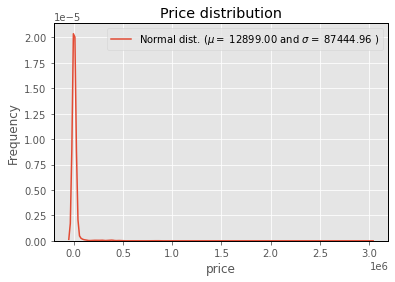

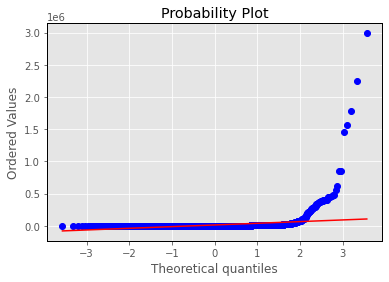

In [23]:
# check if it transformation

# Target mean and stddev
mu, sigma = norm.fit(df_norm_log['price'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

#plot target distribution
sns.kdeplot(df_norm_log['price']);
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#QQ-plot
fig = plt.figure()
res = stats.probplot(df_norm_log['price'], plot=plt)
plt.show()

mu = 8.21 and sigma = 0.91


<IPython.core.display.Javascript object>

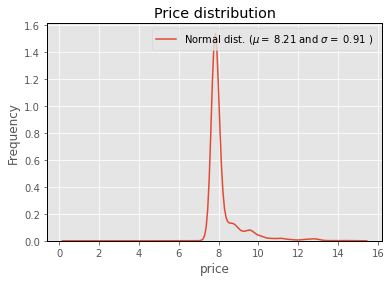

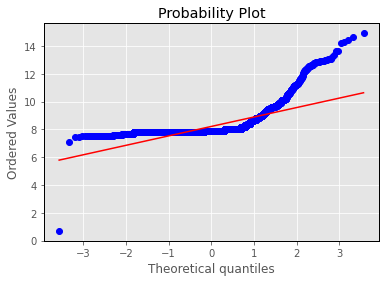

In [24]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_norm_log['price'] = np.log1p(df_norm_log['price']) 
# Target mean and stddev
mu, sigma = norm.fit(df_norm_log['price'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

#plot target distribution
sns.kdeplot(df_norm_log['price']);
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'],
            loc='upper right')
plt.ylabel('Frequency')
plt.title('Price distribution')

#QQ-plot
fig = plt.figure()
res = stats.probplot(df_norm_log['price'], plot=plt)
plt.show()

In [25]:
# Log transform the price for df_rob_too
df_rob_log = df_rob.copy()
df_rob_log['price'] = np.log1p(df_rob_log['price']) 

### Check the dataframes

Will train on these 4 variations to find which one gives best result.

In [30]:
df.head()

,number,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,...,15,16,17,18,19,20,21,22,23,24
0,0.012519,109000,0.666667,0.25,0.0,0.25,0.25,0.430677,0.141237,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.031622,72000,0.666667,0.25,0.0,0.50,0.00,0.349398,0.532474,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.299923,24000,1.000000,0.25,0.5,0.50,0.25,0.418166,0.785567,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.077085,17500,0.666667,0.50,0.0,0.25,0.00,0.646015,0.229897,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.088203,17500,0.666667,0.50,0.0,0.25,0.00,0.646015,0.286082,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
df_rob.head()

,number,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,...,15,16,17,18,19,20,21,22,23,24
0,-1.246857,109000,-1.0,-1.0,0.0,0.0,1.0,-3.456993,-2.777321,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.202741,72000,-1.0,-1.0,0.0,1.0,0.0,-4.706993,-0.282662,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.583148,24000,0.0,-1.0,2.0,1.0,1.0,-3.649401,1.331142,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.097754,17500,-1.0,0.0,0.0,0.0,0.0,-0.145241,-2.211997,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.072079,17500,-1.0,0.0,0.0,0.0,0.0,-0.145241,-1.853739,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [32]:
df_norm_log.head()

,number,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,...,15,16,17,18,19,20,21,22,23,24
0,0.012519,11.599112,0.666667,0.25,0.0,0.25,0.25,0.430677,0.141237,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.031622,11.184435,0.666667,0.25,0.0,0.50,0.00,0.349398,0.532474,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.299923,10.085851,1.000000,0.25,0.5,0.50,0.25,0.418166,0.785567,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.077085,9.770013,0.666667,0.50,0.0,0.25,0.00,0.646015,0.229897,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.088203,9.770013,0.666667,0.50,0.0,0.25,0.00,0.646015,0.286082,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [34]:
df_rob_log.head()

,number,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,...,15,16,17,18,19,20,21,22,23,24
0,-1.246857,11.599112,-1.0,-1.0,0.0,0.0,1.0,-3.456993,-2.777321,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.202741,11.184435,-1.0,-1.0,0.0,1.0,0.0,-4.706993,-0.282662,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.583148,10.085851,0.0,-1.0,2.0,1.0,1.0,-3.649401,1.331142,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.097754,9.770013,-1.0,0.0,0.0,0.0,0.0,-0.145241,-2.211997,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.072079,9.770013,-1.0,0.0,0.0,0.0,0.0,-0.145241,-1.853739,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
### Save all the trainingsets.
df.to_csv('datasets/training/train_norm.csv')
df_rob.to_csv('datasets/training/train_rob.csv')
df_norm_log.to_csv('datasets/training/train_normlog.csv')
df_rob_log.to_csv('datasets/training/train_rob')